# Graphics and tables

Graphics and tables for the paper.

## Setup

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from pathlib import Path

In [2]:
plt.style.use('science')

## Experiments

In [3]:
all_experiments = "2023-08-23-19-57-47"
all_experiments

'2023-08-23-19-57-47'

## Data loading

In [4]:
all_results = dict()
experiments = []

for item in Path("..").glob("data/experiments/*"):
    if item.is_dir() and item.name in all_experiments:
        for experiment in item.glob("*"):
            if experiment.is_dir():
                if (experiment / "results.jsonl").exists():
                    experiment_name = experiment.name
                    print(experiment_name)
                    experiments.append(experiment_name)
                    all_results[experiment_name] = []
                    with open(experiment / "results.jsonl", 'r') as f:
                        for line in f:
                            all_results[experiment_name].append(json.loads(line))

hatexplain-shap-bert_large-2
tweet_sentiment_extraction-lime-bert_large-2
tweet_sentiment_extraction-shap-bert_large-2
hatexplain-lime-bert_large-2


## Plot graphics

In [5]:
def filter_results(results):
    """Filter the results.

    Remove the None and NaN values from the results.

    Args:
        results (list of float): Results to filter.
    
    Returns:
        list of float: Filtered results.
    """
    return [result for result in results \
        if result is not None and not np.isnan(result)]

In [6]:
for explainer in ["lime", "shap"]:
    for negative_rationales in [2]:
        for dataset in ["hatexplain", "tweet_sentiment_extraction"]:
            for model in ["bert_large"]:
                print(f"    \"{dataset}-{explainer}-{model}-{negative_rationales}\": 14,")
        print("")

    "hatexplain-lime-bert_large-2": 14,
    "tweet_sentiment_extraction-lime-bert_large-2": 14,

    "hatexplain-shap-bert_large-2": 14,
    "tweet_sentiment_extraction-shap-bert_large-2": 14,



In [7]:
# Manually copied and pasted from the above print statement
# Manually set the numbers
good_result_map = {
    "hatexplain-lime-bert_large-2": 11,
    "tweet_sentiment_extraction-lime-bert_large-2": 7,
    "hatexplain-shap-bert_large-2": 11,
    "tweet_sentiment_extraction-shap-bert_large-2": 9,
}

In [8]:
def pareto_frontier(x, y):
    """Compute the Pareto frontier of the given points

    Args:
        x (list of float): X coordinates.
        y (list of float): Y coordinates.
    
    Returns:
        list of float: X coordinates of the Pareto frontier.
        list of float: Y coordinates of the Pareto frontier.
    """
    # Revert sort the points
    indices = range(len(x))
    # Sort the points x and, when x is equal, sort by y
    points = sorted(zip(x, y, indices), key=lambda x: (x[0], x[1]))
    points = points[::-1]
    # Add the first point
    frontier_x = [points[0][0]]
    frontier_y = [points[0][1]]
    indices = [points[0][2]]
    # Add the rest of the points
    for point in points[1:]:
        if point[1] > frontier_y[-1]:
            frontier_x.append(point[0])
            frontier_y.append(point[1])
            indices.append(point[2])
    return frontier_x, frontier_y, indices

def plot_graphic(name, results, ax, frontier=False, all_results=False):
    results = sorted(results, key=lambda x: x['weight'])
    if not all_results:
        results = results[1:]  # Remove the first result (cross-entropy weight = 0)
    weights = [result['weight'] for result in results]

    performance_metric = "accuracy"
    explainability_metric = "alternative_auprc"
    x = []
    y = []
    for result in results:
        x.append(result['performance'][performance_metric])
        y.append(
            np.mean(
                filter_results(result['explainability'][explainability_metric])
            )
        )

    if frontier:
        x_frontier, y_frontier, indices = pareto_frontier(x, y)

        sns.scatterplot(
            x="Accuracy",
            y="AUPRC",
            data=pd.DataFrame({
                "Accuracy": x,
                "AUPRC": y,
            }),
            ax=ax,
            color="gray",
            alpha=0.1,
        )
        sns.scatterplot(
            x="Accuracy",
            y="AUPRC",
            data=pd.DataFrame({
                "Accuracy": x_frontier,
                "AUPRC": y_frontier
            }),
            hue=[weights[index] for index in indices],
            ax=ax,
        )
        min_x = min(x_frontier)
        max_x = max(x_frontier)
        min_y = min(y_frontier)
        max_y = max(y_frontier)
        if min_x != max_x:
            size = max_x - min_x
            if size < 1e-4:
                size = 1e-4
            ax.set_xlim(min_x - size*0.3, max_x + size*0.3)
        else:
            ax.set_xlim(min_x - 0.02, max_x + 0.02)
        if min_y != max_y:
            size = max_y - min_y
            if size < 1e-4:
                size = 1e-4
            ax.set_ylim(min_y - size*0.3, max_y + size*0.3)
        else:
            ax.set_ylim(min_y - 0.02, max_y + 0.02)
    else:
        sns.scatterplot(
            x="Accuracy",
            y="AUPRC",
            data=pd.DataFrame({
                "Accuracy": x,
                "AUPRC": y,
            }),
            hue=weights,
            ax=ax,
        )

        if not all_results:
            good_result_index = good_result_map[name]
            x = x[good_result_index]
            y = y[good_result_index]
            ax.scatter(x, y)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    # norm = plt.Normalize(0, max(weights))
    # cmap = sns.cubehelix_palette(as_cmap=True)
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # fig.colorbar(
    #     sm,
    #     orientation="vertical",
    #     label="Cross-entropy weight ($w_1$)",
    # )
    # plt.savefig("accuracy_auprc.pdf", dpi=300, bbox_inches="tight")    

In [9]:
def get_table_line(experiment_name, results):
    results = sorted(results, key=lambda x: x['weight'])
    results = results[1:]  # Remove the first result (cross-entropy weight = 0)
    bad_result = results[-1]
    good_result = results[good_result_map[experiment_name]]
    # x = good_result['performance']['accuracy']
    # y = np.mean(filter_results(good_result['explainability']['alternative_auprc']))
    weight = good_result['weight']

    good_accuracy = good_result['performance']['accuracy']
    bad_accuracy = bad_result['performance']['accuracy']
    accuracy_gain = (good_accuracy - bad_accuracy) * 100

    good_auprc = np.mean(filter_results(good_result['explainability']['alternative_auprc']))
    bad_auprc = np.mean(filter_results(bad_result['explainability']['alternative_auprc']))
    auprc_gain = (good_auprc - bad_auprc) * 100
    auprc_gain_relative = (good_auprc - bad_auprc) / bad_auprc * 100

    good_sufficiency = np.mean(filter_results(good_result['explainability']['sufficiency_aopc']))
    bad_sufficiency = np.mean(filter_results(bad_result['explainability']['sufficiency_aopc']))
    # sufficiency_gain = (good_sufficiency - bad_sufficiency) * 100

    good_random_sufficiency = np.mean(filter_results(good_result['explainability']['random_sufficiency_aopc']))
    bad_random_sufficiency = np.mean(filter_results(bad_result['explainability']['random_sufficiency_aopc']))
    # random_sufficiency_gain = (good_random_sufficiency - bad_random_sufficiency) * 100

    delta_good_sufficiency = -good_sufficiency
    delta_bad_sufficiency = -bad_sufficiency
    sufficiency_gain = (delta_good_sufficiency - delta_bad_sufficiency)

    good_comprehensiveness = np.mean(filter_results(good_result['explainability']['comprehensiveness_aopc']))
    bad_comprehensiveness = np.mean(filter_results(bad_result['explainability']['comprehensiveness_aopc']))
    # comprehensiveness_gain = (good_comprehensiveness - bad_comprehensiveness) * 100

    good_random_comprehensiveness = np.mean(filter_results(good_result['explainability']['random_comprehensiveness_aopc']))
    bad_random_comprehensiveness = np.mean(filter_results(bad_result['explainability']['random_comprehensiveness_aopc']))
    # random_comprehensiveness_gain = (good_random_comprehensiveness - bad_random_comprehensiveness) * 100

    delta_good_comprehensiveness = good_comprehensiveness #  - good_random_comprehensiveness
    delta_bad_comprehensiveness = bad_comprehensiveness #  - bad_random_comprehensiveness
    comprehensiveness_gain = (delta_good_comprehensiveness - delta_bad_comprehensiveness)
    
    return [experiment_name, weight, accuracy_gain, auprc_gain, auprc_gain_relative, sufficiency_gain, comprehensiveness_gain]

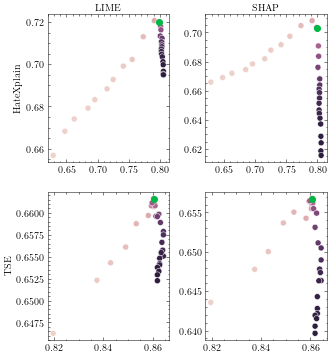

In [10]:
table_all = []
fig = plt.figure(figsize=(5, 6))

datasets = ["hatexplain", "tweet_sentiment_extraction"]
explainers = ["lime", "shap"]
grid = np.array([
    [
        f"{dataset}-{explainer}-{model}-{negative_rationales}" \
            for explainer in explainers \
    ] for dataset in datasets
])
axes = fig.subplot_mosaic(grid)

for key in axes.keys():
    plot_graphic(key, all_results[key], axes[key])
    line = get_table_line(key, all_results[key])
    table_all.append(line)

for key in grid[:, 0]:
    axes[key].set_ylabel({
        "hatexplain": "HateXplain",
        "tweet_sentiment_extraction": "TSE",
    }[key.split("-")[0]])

for key in grid[0]:
    axes[key].set_xlabel({
        "lime": "LIME",
        "shap": "SHAP",
    }[key.split("-")[1]])
    axes[key].xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.3)
plt.savefig(
    f"bert_large_graphic.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
plt.close()

In [11]:
table_all_df = pd.DataFrame(table_all)
table_all_df.columns = ["Model", "w1", "Acc.", "AUPRC", "AUPRC (rel.)", "Suff.", "Comp."]
table_all_df = table_all_df.set_index("Model", inplace=False)
table_all_df.index = [name.replace("tweet_sentiment_extraction", "tse")
                      for name in table_all_df.index]
indices = []
for dataset in ["hatexplain", "tse"]:
    for model in ["bert_large"]:
        for negative_rationales in [2]:
            for explainer in ["lime", "shap"]:
                indices.append(f"{dataset}-{explainer}-{model}-{negative_rationales}")
table_all_df = table_all_df.loc[indices]

table_all_df['w1'] = table_all_df['w1'].apply(
    lambda x: f"{round(x, 2):.2f}" if round(x, 2) != 0.0 else f"{round(x, 3):.3f}"
)
other_columns = ["Acc.", "AUPRC", "AUPRC (rel.)", "Suff.", "Comp."]
table_all_df[other_columns] = table_all_df[other_columns].applymap(
    lambda x: f"{round(x, 2):.2f}"
)
latex = table_all_df.to_latex()
latex = latex.replace("{lllllll}", "{lr|ccccc}")
latex = latex.replace(r"\toprule", r"\hline")
latex = latex.replace(r"\midrule", r"\hline")
latex = latex.replace(r"\bottomrule", r"\hline")
latex = latex.replace(
    r"{} &    w1 &   Acc. & AUPRC & AUPRC (rel.) & Suff. &  Comp. \\",
    r"\textbf{Model}           & \textbf{$w_1$} & \textbf{Acc. \%} & \textbf{AUPRC \%} & \textbf{AUPRC rel. \%} & \textbf{Suff.} & \textbf{Comp.} \\"
)
print(latex)

\begin{tabular}{lr|ccccc}
\hline
\textbf{Model}           & \textbf{$w_1$} & \textbf{Acc. \%} & \textbf{AUPRC \%} & \textbf{AUPRC rel. \%} & \textbf{Suff.} & \textbf{Comp.} \\
\hline
hatexplain-lime-bert\_large-2 &  0.33 &  -0.73 &  2.51 &         3.61 &  0.13 &   0.03 \\
hatexplain-shap-bert\_large-2 &  0.33 &  -0.73 &  8.79 &        14.29 &  0.12 &   0.06 \\
tse-lime-bert\_large-2        &  0.30 &  -0.15 &  0.94 &         1.44 &  0.06 &  -0.01 \\
tse-shap-bert\_large-2        &  0.43 &  -0.12 &  1.71 &         2.68 &  0.05 &  -0.00 \\
\hline
\end{tabular}



In [12]:
table_all_df

,w1,Acc.,AUPRC,AUPRC (rel.),Suff.,Comp.
hatexplain-lime-bert_large-2,0.33,-0.73,2.51,3.61,0.13,0.03
hatexplain-shap-bert_large-2,0.33,-0.73,8.79,14.29,0.12,0.06
tse-lime-bert_large-2,0.30,-0.15,0.94,1.44,0.06,-0.01
tse-shap-bert_large-2,0.43,-0.12,1.71,2.68,0.05,-0.00
